In [36]:
import torch
from torch_geometric.datasets import Planetoid 
from torch_geometric.nn import SGConv 
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [39]:
path = "drive/MyDrive" 
dataset = Planetoid(path, "Cora") 
data = dataset[0] 
print('Cora: ', data)


start_epoch = 1
end_epoch = 51
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


Cora:  Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


Processing...
Done!


In [40]:
class SGCNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = SGConv(in_channels= data.num_features, 
                   out_channels= data.num_features//2, 
                   K = 2, cached =True)
        
        self.conv2 = SGConv(in_channels= data.num_features//2, 
                   out_channels= dataset.num_classes, 
                   K = 2, cached =True)

    def forward(self):
        x = self.conv1(data.x,  data.edge_index) 
        x = self.conv2(x,  data.edge_index)
        return F.log_softmax(x, dim=1)
    


SGC_model, data = SGCNet().to(device), data.to(device)
optimizer = torch.optim.Adam(SGC_model.parameters(), lr=0.2, weight_decay=0.005)

In [41]:
def train_SGCNet():
    SGC_model.train() 
    optimizer.zero_grad() 
    predicted_y = SGC_model() 
    true_y = data.y 
    losses = F.nll_loss(predicted_y[data.train_mask], true_y[data.train_mask])
    losses.backward()
    optimizer.step() 
    return predicted_y

def test_SGCNet():
    SGC_model.eval() 
    logits = SGC_model() 
    accs = []
    for _, mask in data('train_mask', 'val_mask', 'test_mask'):
        pred = logits[mask].max(1)[1] 
        acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
        accs.append(acc)
    return accs

Epoch: 01, Train: 0.5500, Val: 0.2800, Test: 0.3200
Epoch: 02, Train: 0.6786, Val: 0.6680, Test: 0.6770
Epoch: 03, Train: 0.8571, Val: 0.7200, Test: 0.7270
Epoch: 04, Train: 0.8786, Val: 0.7200, Test: 0.7270
Epoch: 05, Train: 0.8429, Val: 0.7200, Test: 0.7270
Epoch: 06, Train: 0.8214, Val: 0.7200, Test: 0.7270
Epoch: 07, Train: 0.8857, Val: 0.7300, Test: 0.7670
Epoch: 08, Train: 0.8929, Val: 0.7400, Test: 0.7520
Epoch: 09, Train: 0.8286, Val: 0.7400, Test: 0.7520
Epoch: 10, Train: 0.8429, Val: 0.7400, Test: 0.7520
Epoch: 11, Train: 0.8357, Val: 0.7400, Test: 0.7520
Epoch: 12, Train: 0.8286, Val: 0.7400, Test: 0.7520
Epoch: 13, Train: 0.8071, Val: 0.7400, Test: 0.7520
Epoch: 14, Train: 0.9000, Val: 0.7520, Test: 0.7610
Epoch: 15, Train: 0.8929, Val: 0.7520, Test: 0.7610
Epoch: 16, Train: 0.9000, Val: 0.7580, Test: 0.7970
Epoch: 17, Train: 0.8929, Val: 0.7600, Test: 0.7880
Epoch: 18, Train: 0.9143, Val: 0.7660, Test: 0.8050
Epoch: 19, Train: 0.9357, Val: 0.7720, Test: 0.7980
Epoch: 20, T

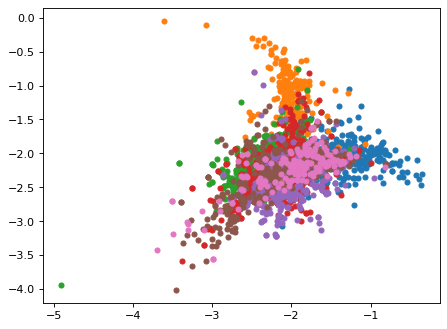

In [42]:
best_val_acc = test_acc = 0
for epoch in range(start_epoch, end_epoch):
    predicted_y = train_SGCNet()
    train_acc, val_acc, tmp_test_acc = test_SGCNet()
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        test_acc = tmp_test_acc
    print('Epoch: {:02d}, Train: {:.4f}, Val: {:.4f}, Test: {:.4f}'.format(epoch, train_acc, best_val_acc, test_acc))

print("\n")
with torch.no_grad():
  y = data.y.cpu().numpy()
  plt.figure(dpi=80)
  for i in range(dataset.num_classes):
      plt.scatter(predicted_y[y==i,0],predicted_y[y==i,1],s=20)
  plt.show()